Human Activity Recognition Time Series Classification

1. Import Libraries/Dataset

In [336]:
# Import Libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from numpy import mean
from numpy import std
from numpy import dstack
import numpy as np
import pandas as pd
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D , Conv1D , MaxPooling1D
import tensorflow.keras.optimizers as optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

In [337]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [338]:
# Upload dataset

from zipfile import ZipFile
filename ="/content/drive/MyDrive/Semester 3/DeepLearning - Mayank/Assignment_2/HARDataset.zip"
with ZipFile(filename, 'r') as zip :
  zip.extractall()
  print('done')


# to get the id part of the file 


done


2. Data Pre-processing

In [339]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

In [341]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	loaded = dstack(loaded)
	return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    #print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    #print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print('trainX : '+ str(trainX.shape))
    print('trainy : '+ str(trainy.shape))
    print('test X : '+ str(testX.shape))
    print('test y : '+ str(testy.shape))
  #	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [ ]:
trainX, trainy, testX, testy = load_dataset()


trainX : (7352, 128, 9)
trainy : (7352, 6)
test X : (2947, 128, 9)
test y : (2947, 6)


3. Data Visualization

[1. 0. 0. 0. 0. 0.]


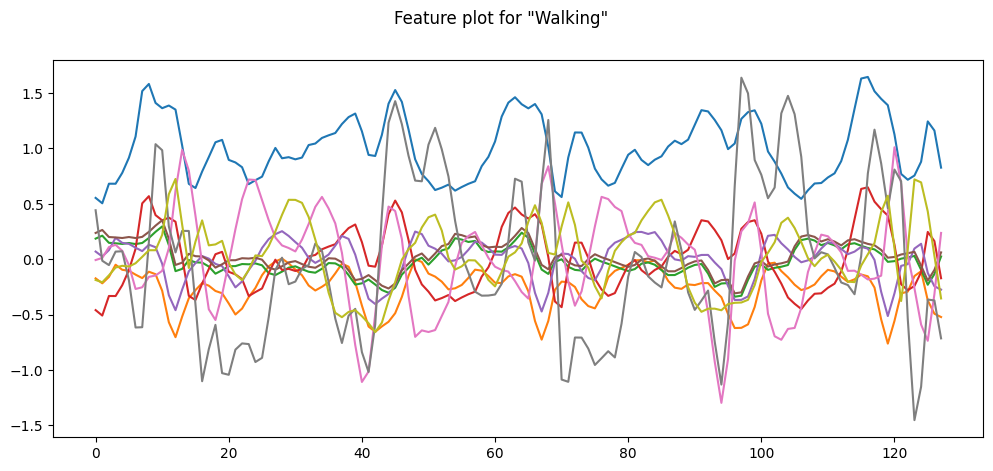

In [ ]:
print(trainy[100])  # Walking
a = trainX[100]
plt.rcParams['figure.figsize'] = [12, 5]
plt.suptitle('Feature plot for "Walking" ')
pyplot.plot(a[:,0])
pyplot.plot(a[:,1])
pyplot.plot(a[:,2])
pyplot.plot(a[:,3])
pyplot.plot(a[:,4])
pyplot.plot(a[:,5])
pyplot.plot(a[:,6])
pyplot.plot(a[:,7])
pyplot.plot(a[:,8])

[0. 0. 0. 0. 0. 1.]


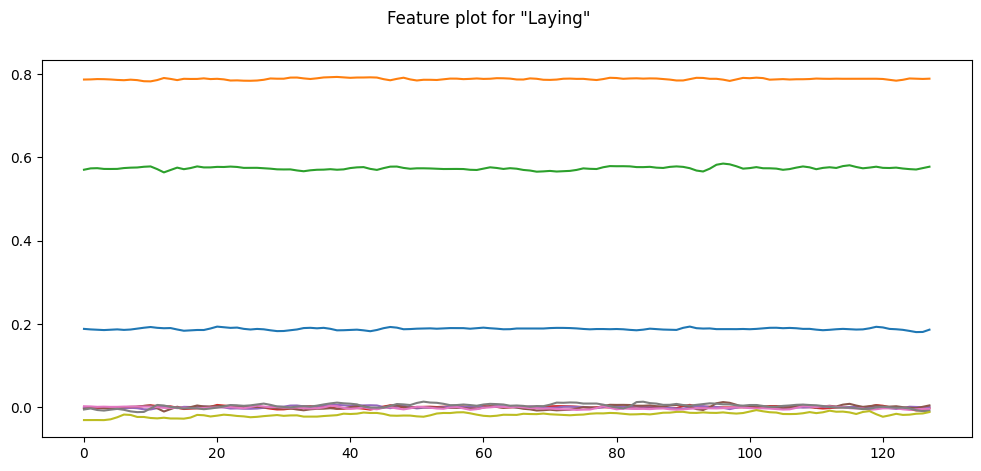

In [ ]:
print(trainy[55])  # Laying
a = trainX[55]
plt.rcParams['figure.figsize'] = [12, 5]
plt.suptitle('Feature plot for "Laying" ')
pyplot.plot(a[:,0])
pyplot.plot(a[:,1])
pyplot.plot(a[:,2])
pyplot.plot(a[:,3])
pyplot.plot(a[:,4])
pyplot.plot(a[:,5])
pyplot.plot(a[:,6])
pyplot.plot(a[:,7])
pyplot.plot(a[:,8])

Text(0.5, 0, 'Timestep')

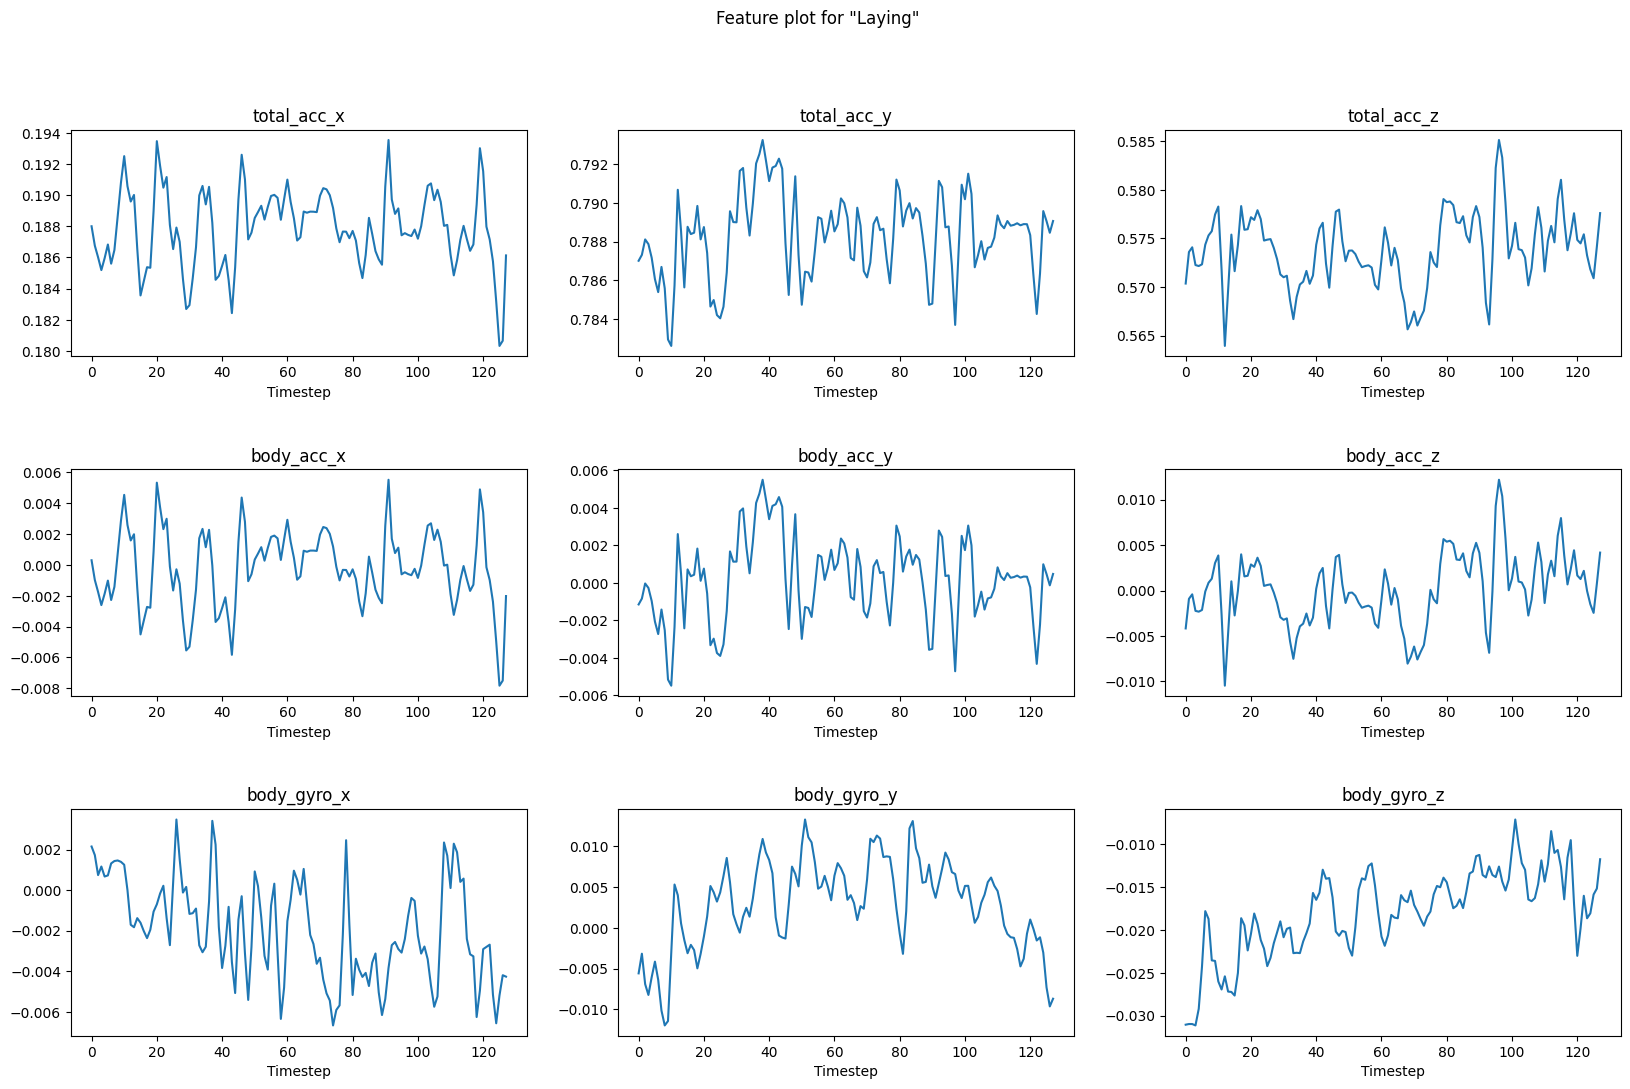

In [ ]:
index_values = ['total_acc_x', 'total_acc_y', 'total_acc_z', 'body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z']
col = list(range(128))
df = pd.DataFrame(data = trainX[55] ,  
                  index = col,  
                  columns = index_values) 
df.head

fig = plt.figure()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
plt.suptitle('Feature plot for "Laying" ')
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['figure.dpi'] = 100 
plt.subplot(3,3,1)
plt.plot(df.total_acc_x[:])
plt.title('total_acc_x')
plt.xlabel('Timestep')

plt.subplot(3,3,2)
plt.plot(df.total_acc_y)
plt.title('total_acc_y')
plt.xlabel('Timestep')

plt.subplot(3,3,3)
plt.plot(df.total_acc_z)
plt.title('total_acc_z')
plt.xlabel('Timestep')

plt.subplot(3,3,4)
plt.plot(df.body_acc_x)
plt.title('body_acc_x')
plt.xlabel('Timestep')

plt.subplot(3,3,5)
plt.plot(df.body_acc_y)
plt.title('body_acc_y')
plt.xlabel('Timestep')

plt.subplot(3,3,6)
plt.plot(df.body_acc_z)
plt.title('body_acc_z')
plt.xlabel('Timestep')

plt.subplot(3,3,7)
plt.plot(df.body_gyro_x)
plt.title('body_gyro_x')
plt.xlabel('Timestep')

plt.subplot(3,3,8)
plt.plot(df.body_gyro_y)
plt.title('body_gyro_y')
plt.xlabel('Timestep')

plt.subplot(3,3,9)
plt.plot(df.body_gyro_z)
plt.title('body_gyro_z')
plt.xlabel('Timestep')


[1. 0. 0. 0. 0. 0.]


Text(0.5, 0, 'Timestep')

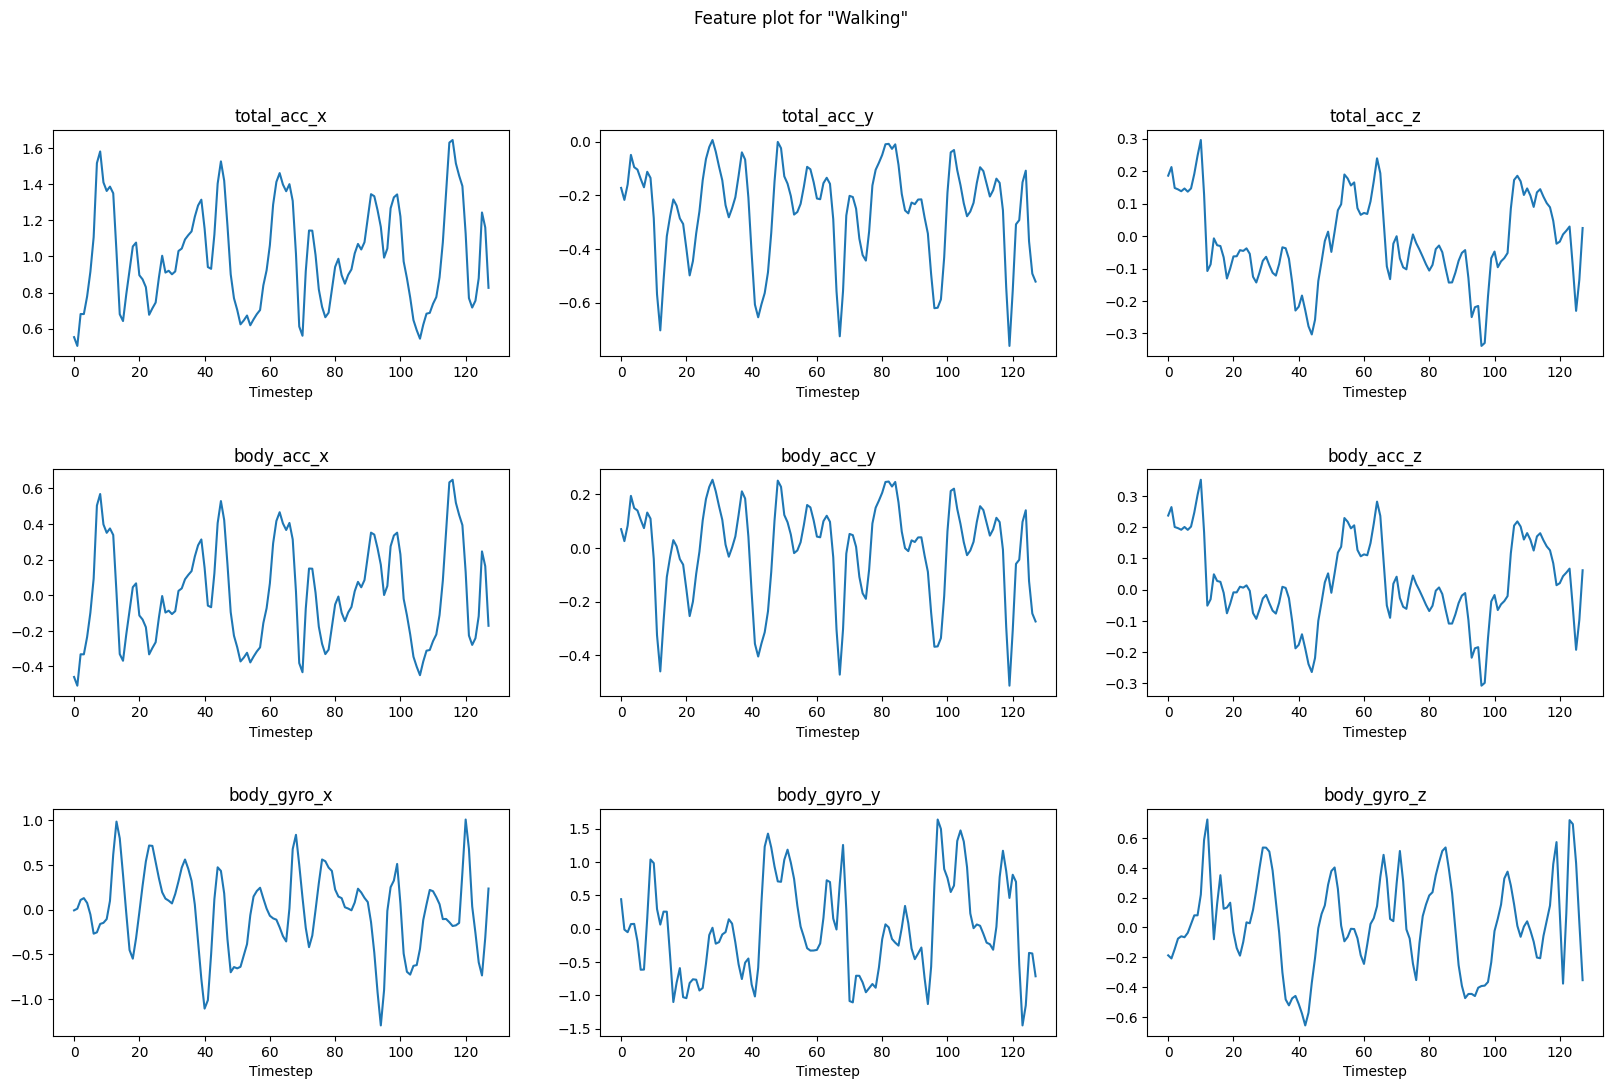

In [ ]:
df = pd.DataFrame(data = trainX[100] ,  
                  index = col,  
                  columns = index_values) 
df.head
print(trainy[100])
fig = plt.figure()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
plt.suptitle('Feature plot for "Walking" ')
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['figure.dpi'] = 100 
plt.subplot(3,3,1)
plt.plot(df.total_acc_x[:])
plt.title('total_acc_x')
plt.xlabel('Timestep')

plt.subplot(3,3,2)
plt.plot(df.total_acc_y)
plt.title('total_acc_y')
plt.xlabel('Timestep')

plt.subplot(3,3,3)
plt.plot(df.total_acc_z)
plt.title('total_acc_z')
plt.xlabel('Timestep')

plt.subplot(3,3,4)
plt.plot(df.body_acc_x)
plt.title('body_acc_x')
plt.xlabel('Timestep')

plt.subplot(3,3,5)
plt.plot(df.body_acc_y)
plt.title('body_acc_y')
plt.xlabel('Timestep')

plt.subplot(3,3,6)
plt.plot(df.body_acc_z)
plt.title('body_acc_z')
plt.xlabel('Timestep')

plt.subplot(3,3,7)
plt.plot(df.body_gyro_x)
plt.title('body_gyro_x')
plt.xlabel('Timestep')

plt.subplot(3,3,8)
plt.plot(df.body_gyro_y)
plt.title('body_gyro_y')
plt.xlabel('Timestep')

plt.subplot(3,3,9)
plt.plot(df.body_gyro_z)
plt.title('body_gyro_z')
plt.xlabel('Timestep')


Model 1: Develop an LSTM Network Model

In [364]:
# Model Building
def evaluate_model_LSTM(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 20, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    rmsprop = optimizers.RMSprop(learning_rate=0.001)
    model = Sequential()
    model.add(LSTM(90, return_sequences=True, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(LSTM(90))
    model.add(Dropout(0.5))
    model.add(Dense(90, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    # Model Compilation
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    model.summary()

    # Model Training
    history = model.fit(trainX, trainy, validation_split=0.33 ,  epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Model Evaluation
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
   
    # list all data in history
    plt.rcParams['figure.figsize'] = [8, 3]
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    # Confusion Matrix
    y_pred=np.argmax(model.predict(testX), axis=-1)
    testy=np.argmax(testy, axis=1)
    matrix=confusion_matrix( testy,y_pred)

    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return accuracy

trainX : (7352, 128, 9)
trainy : (7352, 6)
test X : (2947, 128, 9)
test y : (2947, 6)
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 128, 90)           36000     
_________________________________________________________________
dropout_113 (Dropout)        (None, 128, 90)           0         
_________________________________________________________________
lstm_124 (LSTM)              (None, 90)                65160     
_________________________________________________________________
dropout_114 (Dropout)        (None, 90)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 90)                8190      
_________________________________________________________________
dense_133 (Dense)            (None, 6)                 546       
Total params: 109,896
Trainable p

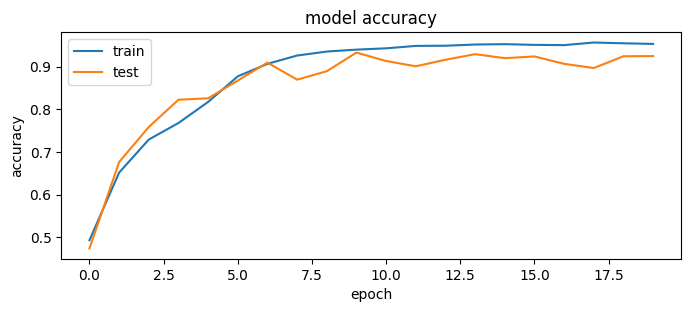

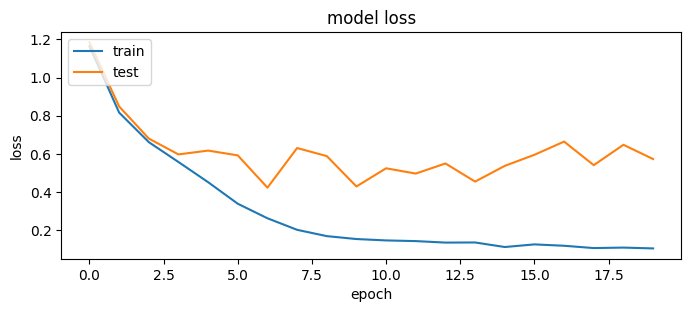

Accuracy: 89.71835970878601
Total time for training:  32.14155888557434 seconds


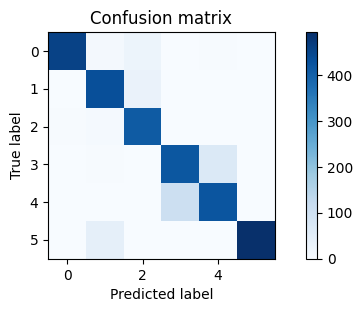

In [365]:
# Model Accuracy
trainX, trainy, testX, testy = load_dataset()

scores = list()
start = time.time()
score = evaluate_model_LSTM(trainX, trainy, testX, testy)
score = score * 100.0
print('Accuracy: ' + str(score))
print("Total time for training: ", time.time() - start, "seconds")

**1. Choice of learning rate value with epoch 20**

1.   Learning rate at 0.1    Accuracy: 18.22192072868347
2.   Learning rate at 0.01   Accuracy: 75.87376832962036
3.   Learning rate at 0.001  Accuracy: 89.71835970878601
4.   Learning rate at 0.0001  Accuracy: 77.7400732040405363

So, based on above data it is observed that accuracy of the model is increased as the learning rate decreases and it is maximum at 0.001.  

**2. Dropout :**
dropout has been added with LSTM layer to prevent model from overfitting.


Model 2: Develop a CNN-LSTM Network Model

In [354]:
# Model Building
def evaluate_model_CNN_LSTM(trainX, trainy, testX, testy):
# fit and evaluate a model

	  # define model
    verbose, epochs, batch_size = 0, 25, 128
    # Choice of learning rate- Accuracy of model increase as the Learning rate decrease . So, at 0.001 model gives maximum accuracy
    adam = optimizers.Adam(learning_rate=0.001)
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(80 , return_sequences=True))
    model.add(LSTM(80 , return_sequences=True))
    model.add(LSTM(80))
    model.add(Dropout(0.5))   # dropout has been added to prevent model from overfitting.
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    # Model Compilation
    model.compile(loss='categorical_crossentropy', optimizer=adam , metrics=['accuracy'])
    model.summary()

    # Model Training
    history = model.fit(trainX, trainy, validation_split=0.33 ,epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Model Evaluation
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  
  
    # list all data in history
    plt.rcParams['figure.figsize'] = [8, 3]
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Confusion Matrix
    y_pred=np.argmax(model.predict(testX), axis=-1)
    testy=np.argmax(testy, axis=1)
    matrix=confusion_matrix( testy,y_pred)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return accuracy

trainX : (7352, 128, 9)
trainy : (7352, 6)
test X : (2947, 128, 9)
test y : (2947, 6)
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_100 (TimeDi (None, None, 30, 256)     7168      
_________________________________________________________________
time_distributed_101 (TimeDi (None, None, 28, 256)     196864    
_________________________________________________________________
time_distributed_102 (TimeDi (None, None, 26, 256)     196864    
_________________________________________________________________
time_distributed_103 (TimeDi (None, None, 26, 256)     0         
_________________________________________________________________
time_distributed_104 (TimeDi (None, None, 13, 256)     0         
_________________________________________________________________
time_distributed_105 (TimeDi (None, None, 3328)        0         
_________________________________

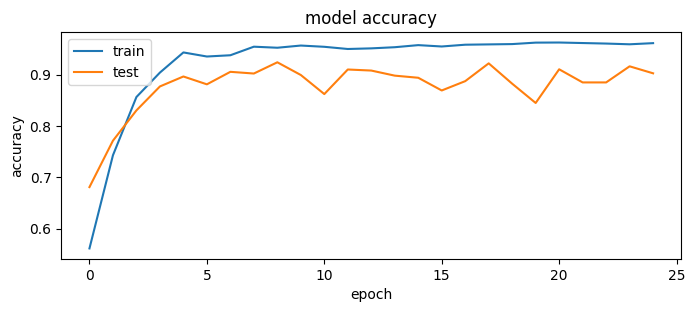

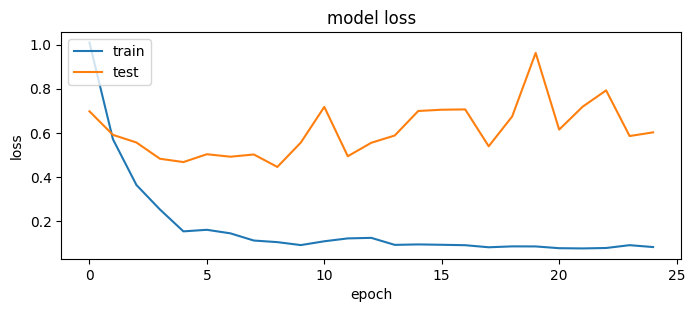

Accuracy: 89.00576829910278
Total time for training:  33.24478054046631 seconds


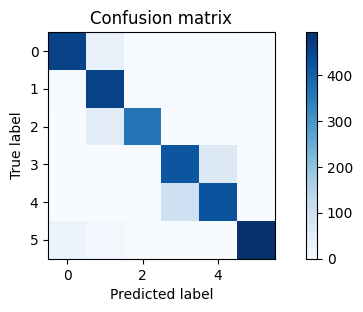

In [355]:
# Model Accuracy
trainX, trainy, testX, testy = load_dataset()
# repeat experiment
scores = list()
start = time.time()
score = evaluate_model_CNN_LSTM(trainX, trainy, testX, testy)
score = score * 100.0
print('Accuracy: ' + str(score))
print("Total time for training: ", time.time() - start, "seconds")